#**0. Thư viện**

##Cài đặt 

In [ ]:
!pip3 install adabound
# !pip3 numpy torc sklearn matplotlib pandas

In [ ]:
# Lib for print table
!pip3 install prettytable

##Import

In [ ]:
# Add Module Path - To Import Custom Modules
# Modules Path
ModulePath = "/content/drive/My Drive/Study/KLTN/Google Colab/0.0 Python Modules/"

import sys
sys.path.append(ModulePath)

In [ ]:
import numpy as np
import pandas as pd
import torch as th
from torch.autograd import Variable as V
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix

# Libs for Keras
from keras.models import load_model


# Own Custom Module to import models and constants
from models import *
from constants import *

import matplotlib.pyplot as plt
import adabound 
import math
from prettytable import PrettyTable
import os
from datetime import date

Using TensorFlow backend.


#**1. Chuẩn bị**

##Paths

In [ ]:
# Base Path
base_path = "/content/drive/My Drive/Study/KLTN/"
Dataset_Path = base_path + "Dataset/NSL-KDD Processed/Final - For Using/"
SavedModelPath = base_path + "Saved Model/"

# Dataset Path
Trainsets_Path = Dataset_Path + 'Trainset/'
g_trainset_path = Trainsets_Path + "GAN-G.csv"
d_trainset_path = Trainsets_Path + "GAN-D.csv"
testset_path = Dataset_Path + "Testset/" + "KDDTest+.csv"


# GAN Saved Models Paths
GAN_Model_Path = SavedModelPath + 'GANModel/'

# Blackbox IDS
IDS_DOS_ModelPath = SavedModelPath + "IDSModel/DOS/" + "Keras_CNN.h5"
IDS_U2R_AND_R2L_ModelPath = SavedModelPath + "IDSModel/U2R_AND_R2L/" + "Keras_CNN.h5"

##Global Variables

In [ ]:
# Global Variables
N_FEATURES = 41
ATTACK_CATEGORIES = ['DOS', 'U2R_AND_R2L']
POS_FUNCTIONAL_FEATURES = {'DOS': DOS_FEATURES, 'U2R_AND_R2L': U2R_AND_R2L_FEATURES}

POS_NONFUNCTIONAL_FEATURES = {}
for attack_category, pos_functional_feature in POS_FUNCTIONAL_FEATURES.items():
    pos_nonfunctional_feature = []
    for i in range(N_FEATURES):
        if i not in pos_functional_feature:
            pos_nonfunctional_feature.append(i)
    POS_NONFUNCTIONAL_FEATURES[attack_category] = pos_nonfunctional_feature

In [ ]:
print('Position of Functional Features\n  ', POS_FUNCTIONAL_FEATURES)
print('Position of Functional Features:\n  ', POS_NONFUNCTIONAL_FEATURES)

Position of Functional Features
   {'DOS': [0, 1, 2, 3, 4, 5, 6, 7, 8, 23, 24, 25, 26, 27, 28, 29, 30], 'U2R_AND_R2L': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]}
Position of Functional Features:
   {'DOS': [9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40], 'U2R_AND_R2L': [23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]}


# **2. Định nghĩa Model**

##Models

In [ ]:
# GAN Model
# GAN - Generator
class Generator(nn.Module):
    def __init__(self,input_dim, output_dim):
        super(Generator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_dim, input_dim//2),
            nn.ReLU(True),
            nn.Linear(input_dim //2, input_dim//2),
            nn.ReLU(True),
            nn.Linear(input_dim // 2, input_dim//2),
            nn.ReLU(True),
            nn.Linear(input_dim//2,input_dim//2),
            nn.ReLU(True),
            nn.Linear(input_dim//2,output_dim),
            # 08/05 - Add Tanh func.
            nn.Tanh()
        )
    def forward(self, noise_dim, raw_attack, attack_category, batch_size):
        '''
        Generate Aversarial Attack Traffic that kept functional features.
        '''
        if attack_category != 'DOS' and attack_category != 'U2R_AND_R2L':
            raise ValueError("Preprocess Data Fail: Invalid Attack Category")
        pos_nonfunctional_feature = POS_NONFUNCTIONAL_FEATURES[attack_category]
        noise = V(th.Tensor(np.random.uniform(0,1,(batch_size, noise_dim))))
        generator_out = self.layer(noise)
        # Keep the functional features
        adversarial_attack = raw_attack.clone()            #.detach() to remove operation history; .clone() to make a copy
        for idx in range(batch_size):
            adversarial_attack[idx][pos_nonfunctional_feature] = generator_out[idx]
        return th.clamp(adversarial_attack,0.,1.)

# GAN - Discriminator
class Discriminator(nn.Module):
    def __init__(self,input_dim, output_dim):
        super(Discriminator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_dim, input_dim*2),
            nn.LeakyReLU(True),
            nn.Linear(input_dim * 2, input_dim *2),
            nn.LeakyReLU(True),
            nn.Linear(input_dim*2 , input_dim*2),
            nn.LeakyReLU(True),
            nn.Linear(input_dim*2,input_dim//2),
            nn.LeakyReLU(True),
            nn.Linear(input_dim//2,output_dim)
        )
    def forward(self,x):
        return self.layer(x)

##Functions

In [ ]:
# Hàm tạo Aversarial Attack Traffic
def create_adversarial_attack_traffic(generator, attack_traffic, attack_category):
    noise = MakeNoise(attack_category, len(attack_traffic), np.array(attack_traffic).shape[1])  
    z = V(th.Tensor(noise))
    adversarial_attack = generator(z)
    return Retain_Features(adversarial_attack, attack_traffic, attack_category)

# Compute Gradient Penalty
def compute_gradient_penalty(D, normal_t, attack_t):
    alpha = th.Tensor(np.random.random((normal_t.shape[0], 1)))
    between_n_a = (alpha * normal_t + ((1 - alpha) * attack_t)).requires_grad_(True)
    d_between_n_a = D(between_n_a)
    adv = V(th.Tensor(normal_t.shape[0], 1).fill_(1.0), requires_grad=False)

    gradients = autograd.grad(
        outputs=d_between_n_a,
        inputs=between_n_a,
        grad_outputs=adv,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

# Hàm tạo Batch
def create_batch2(x,batch_size):
    a = list(range(len(x)))
    np.random.shuffle(a)
    x = x[a]
    batch_x = [x[batch_size * i : (i+1)*batch_size,:] for i in range(len(x)//batch_size)]
    return np.array(batch_x)

# Hàm tiền xử lý dữ liệu tấn công
def preprocess_malicious_data(dataset, attack_category):
    # 2 Category: DoS, U2R&R2L
    if attack_category != 'DOS' and attack_category != 'U2R_AND_R2L':
      raise ValueError("Preprocess Data Fail: Invalid Attack Category")
    
    attack_data = dataset[dataset['class'] == attack_category]
    # Del label
    del attack_data["class"]
    return np.array(attack_data)

# **3. Run Model**

##**3.1 Run IDSGAN**

In [ ]:
# Hyber Parameters
BATCH_SIZE = 64
MAX_EPOCH = 100
learning_rate = 0.0001
LAMBDA = 10
CLAMP = 0.01
CRITIC_ITERS = 5          # For WGAN and WGAN-GP, number of critic iters per gen iter

# GAN-D
D_INPUT_DIM = N_FEATURES
D_OUTPUT_DIM = 1
discriminator = Discriminator(D_INPUT_DIM,D_OUTPUT_DIM)
optimizer_D = optim.RMSprop(discriminator.parameters(), lr=learning_rate)

# GAN-G
NOISE_DIM = 9
G_INPUT_DIM = NOISE_DIM     # Generator input dimension is dimention of noise

In [ ]:
# IDS model name
ids_model_name = 'CNN'
adversarial_attack_type = 'AdversarialAttack1'

# Create Folder for save GAN adversarial with IDS Model.
GAN_4IDS_Model_Path = str(f"{GAN_Model_Path}{ids_model_name}/")
directory = GAN_4IDS_Model_Path
if not os.path.exists(directory):
        os.makedirs(directory)

# Get today to set created time for GAN models
today = str(date.today())

## Prepare Dataset
g_train_data = pd.read_csv(g_trainset_path)
d_train_data = pd.read_csv(d_trainset_path)

# All normal record in train_data
del d_train_data["class"]
normal = np.array(d_train_data)

print("Amout of Generator Trainset:", g_train_data.shape[0])
print("Amout of Discriminator Trainset:", d_train_data.shape[0])

Amout of Generator Trainset: 23488
Amout of Discriminator Trainset: 33672


***IDSGAN start training
 -> Attack Category: DOS; IDS Model: CNN
 -> Load IDS Model from: /content/drive/My Drive/Study/KLTN/Saved Model/IDSModel/DOS/Keras_CNN.h5
     Epoch               G-Loss                  D-Loss
         1               -2.9565                  -3.5051
         2               -4.2853                  -2.1915
         3               -8.5197                  -1.9011
         4               -8.1541                  -1.7015
         5               -5.0496                  -2.0852
         6               -5.0691                  -2.1198
         7               -4.5485                  -2.1320
         8               -1.8230                  -2.1406
         9               -2.0192                  -2.1409
        10               -3.5416                  -2.1350
  -> Saved Generator 10 epoch to disk.
        11               -2.5543                  -2.1412
        12               -1.8293                  -2.1307
        13               -1.8679             

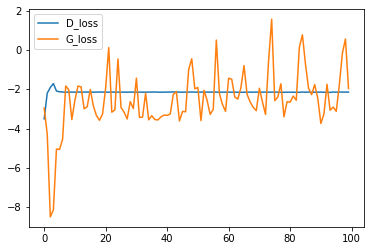

  -> Saved Discrimninator 100 epoch to disk.
***IDSGAN start training
 -> Attack Category: U2R_AND_R2L; IDS Model: CNN
 -> Load IDS Model from: /content/drive/My Drive/Study/KLTN/Saved Model/IDSModel/U2R_AND_R2L/Keras_CNN.h5
     Epoch               G-Loss                  D-Loss
         1               -4.9855                  -1.1619
         2               -6.0431                  -1.4784
         3               -6.5981                  -1.3984
         4               -7.2817                  -1.3178
         5               -7.6578                  -1.2929
         6               -6.8030                  -1.3073
         7               -6.8415                  -1.2515
         8               -5.0089                  -1.3130
         9               -5.8868                  -1.2773
        10               -6.7889                  -1.2368
  -> Saved Generator 10 epoch to disk.
        11               -6.5909                  -1.2448
        12               -6.6672          

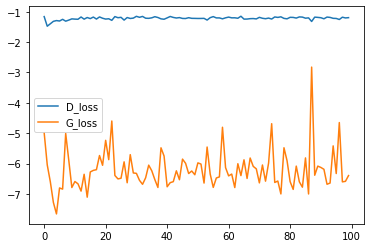

  -> Saved Discrimninator 100 epoch to disk.


In [ ]:
# for attack_category in ATTACK_CATEGORIES:
#     print(f"{100*'='}\n***IDSGAN start training")
#     print(f" -> Attack Category: {attack_category}; IDS Model: {ids_model_name}")
    
#     # Create GAN-G model for specific attack category
#     G_OUTPUT_DIM = len(POS_NONFUNCTIONAL_FEATURES[attack_category])     # Generator output is number of nonfunctional feature
#     generator = Generator(G_INPUT_DIM,G_OUTPUT_DIM)
#     optimizer_G = optim.RMSprop(generator.parameters(), lr=learning_rate)

#     # Load Raw Attack Dataset
#     raw_attack = preprocess_malicious_data(g_train_data, attack_category)

#     # Load IDS Keras Model
#     if attack_category == 'DOS':
#         ids_model_path = IDS_DOS_ModelPath
#     elif attack_category == 'U2R_AND_R2L':
#         ids_model_path = IDS_U2R_AND_R2L_ModelPath
#     ids_model = load_model(ids_model_path)
#     print(f" -> Load IDS Model from: {ids_model_path}")
#     # ids_model.summary()
    
#     # Prepare Save Folder.
#     GAN_G_Model_4Category_Path = str(f"{GAN_4IDS_Model_Path}{attack_category}/Generator/{adversarial_attack_type}/")
#     GAN_D_Model_4Category_Path = str(f"{GAN_4IDS_Model_Path}{attack_category}/Discriminator/{adversarial_attack_type}/")
#     for directory in [GAN_G_Model_4Category_Path, GAN_D_Model_4Category_Path]:
#         if not os.path.exists(directory):
#             os.makedirs(directory)

#     # Declare Loss List and Train GAN-G, GAN-D
#     d_losses,g_losses = [],[]
#     generator.train()
#     discriminator.train()

#     # Create batch of attack traffic
#     batch_attack = create_batch2(raw_attack,BATCH_SIZE)


#     table_result = PrettyTable(['Epoch', 'G-Loss', 'D-Loss'])
#     print(f"{5*' '}Epoch{15*' '}G-Loss{18*' '}D-Loss")

#     for epoch in range(MAX_EPOCH):
#         cnt = 0
#         batch_normal = create_batch2(normal,BATCH_SIZE)
#         run_g_loss = 0.
#         run_d_loss = 0.

#         for idx, bn in enumerate(batch_normal):
#             normal_b = th.Tensor(bn.astype("float64"))
#             attack_traffic  = V(th.Tensor(batch_attack[idx % len(batch_attack)]))
#             #  Train Generator
#             for p in discriminator.parameters():  
#                 p.requires_grad = False
        
#             optimizer_G.zero_grad()        
            
#             # # Create Adversarial Attack Traffic
            
#             adversarial_attack = generator(noise_dim=NOISE_DIM, raw_attack=attack_traffic, attack_category=attack_category, batch_size=len(attack_traffic))

#             D_pred = discriminator(adversarial_attack)
#             g_loss = -th.mean(D_pred)

#             g_loss.backward()
#             optimizer_G.step()
            
#             run_g_loss += g_loss.item()
#             # Train Discreminator
#             for p in discriminator.parameters(): 
#                 p.requires_grad = True

#             for c in range(CRITIC_ITERS):
#                 optimizer_D.zero_grad()
#                 for p in discriminator.parameters():
#                     p.data.clamp_(-CLAMP, CLAMP)
                    
#                 adversarial_attack = generator(noise_dim=NOISE_DIM, raw_attack=attack_traffic, attack_category=attack_category, batch_size=len(attack_traffic))
#                 ids_input = th.cat((adversarial_attack,normal_b))

#                 # Shuffle Input
#                 l = list(range(len(ids_input)))
#                 np.random.shuffle(l)
#                 ids_input = V(th.Tensor(ids_input[l]))
#                 # Change Format for Keras
#                 ids_input_keras = ids_input.reshape(ids_input.shape[0], N_FEATURES, 1)
#                 ids_pred = ids_model.predict(ids_input_keras)
#                 # to torch.tensor
#                 ids_pred = V(th.Tensor(ids_pred))
#                 ids_pred_lable = th.argmax(nn.Sigmoid()(ids_pred),dim = 1).detach().numpy()

#                 pred_normal = ids_input.numpy()[ids_pred_lable==0]
#                 pred_attack = ids_input.numpy()[ids_pred_lable==1]
                

#                 if len(pred_attack) == 0:
#                     cnt += 1
#                     break
#                 D_noraml = discriminator(V(th.Tensor(pred_normal)))
#                 D_attack= discriminator(V(th.Tensor(pred_attack)))
                
#                 loss_normal = th.mean(D_noraml)
#                 loss_attack = th.mean(D_attack)
#                 gradient_penalty = compute_gradient_penalty(discriminator, normal_b.data, adversarial_attack.data)

#                 d_loss = loss_attack - loss_normal #+ LAMBDA * gradient_penalty

#                 d_loss.backward()
#                 optimizer_D.step()
#                 run_d_loss += d_loss.item()
                
#         d_losses.append(run_d_loss/CRITIC_ITERS)
#         g_losses.append(run_g_loss)
#         print(f"{5*' '}{epoch + 1:5d}{15*' '}{run_g_loss:3.4f}{18*' '}{run_d_loss/CRITIC_ITERS:3.4f}")
#         # print(f"G_Loss = {run_g_loss} \t D_Loss = {run_d_loss/CRITIC_ITERS}")
#         table_result.add_row([epoch + 1, run_g_loss, run_d_loss/CRITIC_ITERS])

#         if cnt >= (len(normal)/BATCH_SIZE):
#             print("Not exist predicted attack traffic")
#             break
        
#         # Save Adversarial Dataset each 10 epoch
#         if ((epoch + 1) % 10 == 0):
#             th.save(generator.state_dict(), GAN_G_Model_4Category_Path + f"{epoch + 1}epoch_time_created_{today}.pth")
#             print(f"  -> Saved Generator {epoch + 1} epoch to disk.")
#     print("IDSGAN finish training\nResult Table")
#     print(table_result)
#     # Show Graph
#     plt.plot(d_losses,label = "D_loss")
#     plt.plot(g_losses, label = "G_loss")
#     plt.legend()
#     plt.show()

#     # Save Model
#     th.save(discriminator.state_dict(), GAN_D_Model_4Category_Path + f"{MAX_EPOCH + 1}epoch_time_created_{today}.pth")
#     print(f"  -> Saved Discrimninator {MAX_EPOCH} epoch to disk.")

#**3. Run Generate Adversarial Traffic**

###**Hyber Parameters**

In [ ]:
# Declare Hyber Parameters
BATCH_SIZE = 256 # Batch size
MAX_EPOCH = 100

# GAN-G
NOISE_DIM = 9
G_INPUT_DIM = NOISE_DIM     # Generator input dimension is dimention of noise

###**Generate Traffic**

In [ ]:
ids_model_name = 'CNN'
gan_model_time_created = str(date.today())
adversarial_attack_type = 'AdversarialAttack1'

# Load Testset
testset = pd.read_csv(testset_path)
print(f"Amount of KDDTest+: \t\t{len(testset)}")
# test_normal
test_normal = np.array(testset[testset["class"] == 'Normal'])[:,:-1]
# Create batch of normal traffic
test_batch_normal = create_batch2(test_normal,BATCH_SIZE).astype('float64')
print(f"Amount of Normal:\t\t{len(test_normal)} ({len(test_batch_normal)} batchs - {BATCH_SIZE} records/batch)")

Amount of KDDTest+: 		20123
Amount of Normal:		9711 (37 batchs - 256 records/batch)


In [ ]:
# Adversarial Traffic Evaluating
print("***Adversarial Traffic Evaluating***")
print(f" Type : {adversarial_attack_type}")
print("-"*100)

print(f"IDS Model: {ids_model_name}")

for attack_category in ATTACK_CATEGORIES:
    print(f"{5*'*'}\n - Attack Category: {attack_category}")
    # Load Attack Dataset
    test_raw_attack = preprocess_malicious_data(testset, attack_category)
    # Create batch of attack traffic
    batch_attack = create_batch2(test_raw_attack, BATCH_SIZE)
    n_batch_attack = len(batch_attack)

    print(f"{4*' '}Amout of {attack_category}:\t{len(test_raw_attack)} ({n_batch_attack} batchs - {BATCH_SIZE} records/batch)")
    
    # Load IDS Model
    ids_model_path = str(f"{SavedModelPath}IDSModel/{attack_category}/Keras_{ids_model_name}.h5")
    ids_model = load_model(ids_model_path)
    print(f"{4*' '}Load IDS {attack_category} Model from: {ids_model_path}")

    for epoch in range(10, MAX_EPOCH + 1, 10):
        # Load GAN-G Model
        G_OUTPUT_DIM = len(POS_NONFUNCTIONAL_FEATURES[attack_category])     # Generator output is number of nonfunctional feature
        generator = Generator(G_INPUT_DIM,G_OUTPUT_DIM)
        GAN_G_Model_Path = str(f"{GAN_Model_Path}{ids_model_name}/{attack_category}/Generator/temp/{adversarial_attack_type}/{epoch}epoch_time_created_{gan_model_time_created}.pth")
        param = th.load(GAN_G_Model_Path,map_location=lambda x,y:x)
        generator.load_state_dict(param)
        generator.eval()

        o_dr,a_dr =[],[]
        with th.no_grad():
            for idx, bn in enumerate(test_batch_normal):
                normal_b = th.Tensor(bn)
                attack_b = th.Tensor(batch_attack[idx % n_batch_attack])

                # Generate Adversarial Traffic
                adversarial_attack_b = generator(noise_dim=NOISE_DIM, raw_attack=attack_b, attack_category=attack_category, batch_size=BATCH_SIZE)

                # IDS Input
                ori_input = th.cat((attack_b,normal_b))
                adv_input = th.cat((adversarial_attack_b,normal_b))
                l = list(range(len(ori_input)))
                np.random.shuffle(l)
                
                adv_input = adv_input[l]
                ori_input = ori_input[l]
                # Reshape for Keras Model
                adv_input = adv_input.reshape(adv_input.shape[0], N_FEATURES, 1)
                ori_input = ori_input.reshape(ori_input.shape[0], N_FEATURES, 1)

                # Predict
                o_pred_label = np.argmax((ids_model.predict(ori_input)),axis = 1)
                a_pred_lable = np.argmax((ids_model.predict(adv_input)),axis = 1)

                ids_true_label = np.r_[np.ones(BATCH_SIZE),np.zeros(BATCH_SIZE)][l]

                tn1, fn1, fp1, tp1 = confusion_matrix(ids_true_label,a_pred_lable).ravel()
                tn2, fn2, fp2, tp2 = confusion_matrix(ids_true_label,o_pred_label).ravel()

                a_dr.append(tp1/(tp1 + fp1))
                o_dr.append(tp2/(tp2 + fp2))
        eir = 1 - (np.mean(a_dr)/np.mean(o_dr))
        print(f"\t {epoch:3d} epochs:\tOrigin DR : {np.mean(o_dr)*100:.2f}% \t Adversarial DR : {np.mean(a_dr)*100:.2f}% \t EIR : {eir*100:.2f}%")

***Adversarial Traffic Evaluating***
 Type : AdversarialAttack1
----------------------------------------------------------------------------------------------------
IDS Model: CNN
*****
 - Attack Category: DOS
    Amout of DOS:	7460 (29 batchs - 256 records/batch)
    Load IDS DOS Model from: /content/drive/My Drive/Study/KLTN/Saved Model/IDSModel/DOS/Keras_CNN.h5
	  10 epochs:	Origin DR : 80.47% 	 Adversarial DR : 0.58% 	 EIR : 99.28%
	  20 epochs:	Origin DR : 80.47% 	 Adversarial DR : 0.58% 	 EIR : 99.28%
	  30 epochs:	Origin DR : 80.47% 	 Adversarial DR : 0.58% 	 EIR : 99.28%
	  40 epochs:	Origin DR : 80.47% 	 Adversarial DR : 0.58% 	 EIR : 99.28%
	  50 epochs:	Origin DR : 80.47% 	 Adversarial DR : 0.58% 	 EIR : 99.28%
	  60 epochs:	Origin DR : 80.47% 	 Adversarial DR : 0.58% 	 EIR : 99.28%
	  70 epochs:	Origin DR : 80.47% 	 Adversarial DR : 0.58% 	 EIR : 99.28%
	  80 epochs:	Origin DR : 80.47% 	 Adversarial DR : 0.58% 	 EIR : 99.28%
	  90 epochs:	Origin DR : 80.47% 	 Adversarial DR

The Saved Model stored in [Google Drive - GAN Model](https://drive.google.com/drive/u/1/folders/1VNFW-k5SbR0eGsJ_np3U-W3Rcz_n4I8N)

The Result of Code stored in [Github - Thesis](https://github.com/thetinybug/thesis-IDSGAN)